In [ ]:
# 데이터 zip파일 압축 풀기

!unzip './drive/MyDrive/CLASS/week11/data/cats_and_dogs.zip' -d '/content'

In [ ]:
from torchvision.io import read_image
from torch.utils.data import Dataset
import pandas as pd
from torch.utils.data import DataLoader

In [ ]:
# 이미지 데이터 불러오는 함수

class CustomImageDataset(Dataset):
  def __init__(self,img_dir,transform=None):
    self.img_labels = pd.read_csv(f'{img_dir}/label.csv')
    self.img_dir = img_dir
    self.transform = transform

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self,idx):
    img_path = f'{self.img_dir}/{self.img_labels.iloc[idx,0]}'
    img = read_image(img_path)
    if self.transform:
      img = self.transform(img)
    label = self.img_labels.iloc[idx,1]
    return img,label

In [ ]:
# 데이터 정의

from torchvision.models import resnet18, ResNet18_Weights

weights = ResNet18_Weights.IMAGENET1K_V1
transform = weights.transforms()

train_dataset = CustomImageDataset("./cats_and_dogs/train", transform=transform)
test_dataset = CustomImageDataset("./cats_and_dogs/test", transform=transform)

In [ ]:
# 데이터로더 배치 정의

from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset,batch_size=32,shuffle=True)
test_dataloader = DataLoader(test_dataset,batch_size=32,shuffle=False)

In [ ]:
# 이미지 확인 함수

def plot_batch(batch, label_dict, cmap=None):
    img_tensor_batch = batch[0]
    label_batch = batch[1]
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    for i, ax in enumerate(axes.flat):
        img_tensor = img_tensor_batch[i]
        img_array = img_tensor.numpy().transpose(1, 2, 0)
        ax.imshow(img_array, cmap=cmap)
        ax.set_title(f"{label_dict[label_batch[i].item()]}")

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


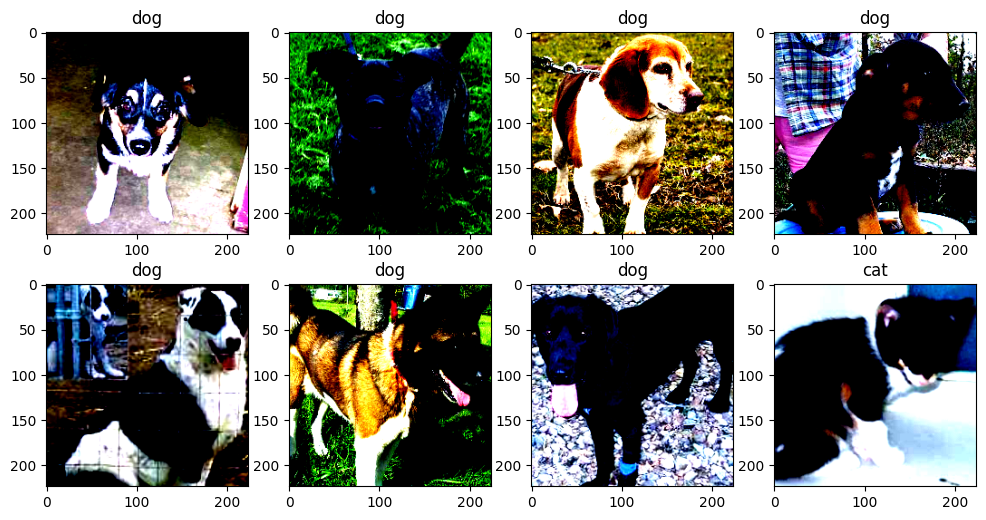

In [ ]:
# 레이블 지정 및 확인

from matplotlib import pyplot as plt

label_dict = {0: "cat", 1: "dog"}
for batch in train_dataloader:
    plot_batch(batch, label_dict)
    break

## 학습 함수 정의

In [ ]:
def get_mean(metrics):
    return round(sum(metrics) / len(metrics), 4)

In [ ]:
from collections import defaultdict
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score


def train_model(model):
    model.train()
    loss_list = []
    acc_list = []
    for x_train, y_train in tqdm(train_dataloader):
        x_train = x_train.to(device)
        y_train = y_train.to(device)

        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss_list.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred = torch.argmax(outputs, dim=1)
        acc = ((y_train == pred).sum() / len(y_train)).item()
        acc_list.append(acc)
    return get_mean(loss_list), get_mean(acc_list)

In [ ]:
def validate_model(model):
    model.eval()
    loss_list = []
    acc_list = []
    for x_val, y_val in tqdm(test_dataloader):
        x_val = x_val.to(device)
        y_val = y_val.to(device)
        with torch.no_grad():
            outputs = model(x_val)
            loss = criterion(outputs, y_val)
            loss_list.append(loss.item())

            pred = torch.argmax(outputs, dim=1)
            acc = ((y_val == pred).sum() / len(y_val)).item()
            acc_list.append(acc)
    return get_mean(loss_list), get_mean(acc_list)

In [ ]:
from collections import defaultdict

def train_validate_model(model):
    logs = defaultdict(list)
    for epoch in range(epochs):
        train_loss, train_acc = train_model(model)
        val_loss, val_acc = validate_model(model)
        logs["train_loss"].append(train_loss)
        logs["train_acc"].append(train_acc)
        logs["val_loss"].append(val_loss)
        logs["val_acc"].append(val_acc)
        print(f"epoch {epoch + 1} train - loss: {train_loss} acc: {train_acc} val - loss: {val_loss} acc: {val_acc}")
    return logs

In [ ]:
def plot_logs(logs):
    fig = plt.figure(figsize=(10, 4))

    ax0 = fig.add_subplot(1, 2, 1)
    ax1 = fig.add_subplot(1, 2, 2)
    ax0.plot(logs["train_loss"], label="train")
    ax0.plot(logs["val_loss"], label="val")
    ax0.legend()
    ax0.set_title("loss")

    ax1.plot(logs["train_acc"], label="train")
    ax1.plot(logs["val_acc"], label="val")
    ax1.legend()
    ax1.set_title("accuracy")
    plt.legend()

In [ ]:
# cpu - gpu 변경

import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = resnet18().to(device)

In [ ]:
# 모델 클래스 분류 확인

from torchsummary import summary

summary(model,input_size=(3,224,224))

In [ ]:
# 모델 클래스 분류 변경

model.fc = torch.nn.Linear(in_features = 512, out_features = 2)
model.to(device)

In [ ]:
# 클래스 수 변경 후 모델 재확인

summary(model,input_size=(3,224,224))

In [ ]:
model = resnet18(weights=weights)

for param in model.parameters():
  param.requires_grad = False

for param in model.layer4.parameters():
  param.requires_grad = True

model.fc = torch.nn.Linear(in_features = 512, out_features = 2)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 157MB/s]


In [ ]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()
epochs = 10

  0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 63/63 [00:14<00:00,  4.44it/s]


epoch 1 train - loss: 0.1035 acc: 0.9581 val - loss: 0.1033 acc: 0.9717


100%|██████████| 63/63 [00:13<00:00,  4.55it/s]


epoch 2 train - loss: 0.049 acc: 0.9816 val - loss: 0.0781 acc: 0.9732


100%|██████████| 63/63 [00:15<00:00,  4.01it/s]


epoch 3 train - loss: 0.0304 acc: 0.9889 val - loss: 0.0868 acc: 0.9742


100%|██████████| 63/63 [00:13<00:00,  4.64it/s]


epoch 4 train - loss: 0.021 acc: 0.9919 val - loss: 0.1199 acc: 0.9757


100%|██████████| 63/63 [00:14<00:00,  4.27it/s]


epoch 5 train - loss: 0.0311 acc: 0.9892 val - loss: 0.0824 acc: 0.9812


100%|██████████| 63/63 [00:13<00:00,  4.63it/s]


epoch 6 train - loss: 0.0118 acc: 0.9962 val - loss: 0.1924 acc: 0.9519


100%|██████████| 63/63 [00:14<00:00,  4.35it/s]


epoch 7 train - loss: 0.0161 acc: 0.9941 val - loss: 0.0944 acc: 0.9767


100%|██████████| 63/63 [00:14<00:00,  4.38it/s]


epoch 8 train - loss: 0.0086 acc: 0.997 val - loss: 0.1 acc: 0.9787


100%|██████████| 63/63 [00:14<00:00,  4.33it/s]


epoch 9 train - loss: 0.0093 acc: 0.9969 val - loss: 0.0991 acc: 0.9841


100%|██████████| 63/63 [00:13<00:00,  4.68it/s]


epoch 10 train - loss: 0.0123 acc: 0.996 val - loss: 0.0785 acc: 0.9831


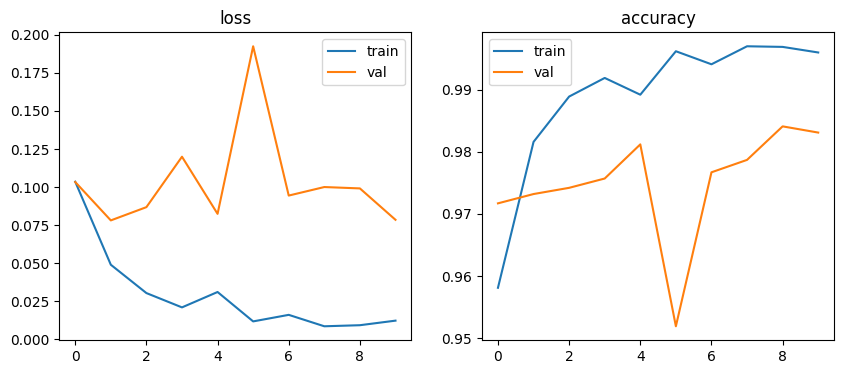

In [ ]:
logs = train_validate_model(model)
plot_logs(logs)